## Tasselled Cap Wetness transform to look at extent of 'wetness' in the Southern Stuart Corridor



### Based on the Crist 1985 RF coefficients

- be aware of terrain shadow on southwest facing slopes - can show up as 'wetness' - would use nbart but having some terrain masking issues today...


### This is running it for all sensors - despite being the 1985 paper

-------------------------------------------------------------------- 
The following sensors are available for the following time frames:
* Landsat 5 - 1986 to April 1999  followed by a gap until May 2003 - November 2011 (data from 2009 onwards becomes less reliable in southern Australia)
* Landsat 7 - April 1999 to present, however after May 2003 the scan line corrector (SLC) failed, 
so data are referred to as SLC-off, meaning they've got a venetian blinds appearance with wedges of missing data
  * This data is not well suited for inclusion in composites, but is fine to use in time series analysis
* Landsat 8 - April 2013 onwards
---------------------------------------------------------------------

### import some modules

In [8]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#use this to find the number of scenes available
from datacube.model import Range

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

#import module to work with rgb images
from PIL import Image

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)
        
    

In [9]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written by bex dunn 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

In [10]:
#calculating tasselled cap wetness
def calc_wetness(sensor_data,sensor):
    '''This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce a "wetness" "band".
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Crist and Cicone 1985 "A TM Tasseled Cap equivalent transformation for reflectance factor data"
    function written 23-08-2017 based on dc v1.5.1. updated 19-10-2017 bd'''

    wetness_coeff = {'ls5':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109},
                    'ls7':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109},
                    'ls8':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109}}
    #if there is sensor data for the time period
    if sensor_data is not None: 
         # make a deep copy of the sensor data
        wbg = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            wetness_band = sensor_data[band_name]*wetness_coeff[sensor][band_name]
            #update the existing band data with the TC data
            #by making new bands, called wet_green, bright_green etc.
            wbg.update({'wet_'+band_name:(['time','y','x'],wetness_band)})
            #then drop the original bands
            wbg = wbg.drop({band_name})    
        #sum the values for each band to get the tcw dim    
        wbg['wetness']=wbg.wet_blue+wbg.wet_green+wbg.wet_red+wbg.wet_nir+wbg.wet_swir1+wbg.wet_swir2
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('wetness')    
        wbg = wbg.drop(bands_to_drop)
        print('calculated wetness for {}'.format(sensor))
        return wbg    
    else:
        print('did not calculate wetness for {}'.format(sensor))
        return None            

In [11]:
def calc_wetveg_overthresh(wetness,threshold=-400):
    '''Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.'''
    if wetness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            #water_plus_wetveg is wetness values where wetness>threshold
            wetness['water_plus_wetveg'] = wetness.wetness.where(wetness.wetness>threshold)
            print('thresholded wetness added to array')
            return wetness
    else:
        print('did not calculate wetness overthreshold' )
        return None    

In [12]:
def count_wets(wetness):
    '''count the number of wetness scenes for each pixel,
    count the amount of times that water plus wet veg is above the threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of wet count and threshold count'''
    if wetness is not None:
        #count the number of wetness scenes for each pixel
        wet_count = wetness.wetness.count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= wetness.water_plus_wetveg.count(dim='time')
        
        #bring both counts into memory
        wet_count.load()
        threshold_count.load()
        
        #define dictionary of wet count and threshold count
        counts = {'wet count':wet_count, 'threshold count':threshold_count}
        print('counted')
        return counts
    else:
        print('did not count' )
        return None    

In [13]:
def write_your_netcdf(data, dataset_name, filename,crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    dataset= data.to_dataset(name=dataset_name)
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

## Mainline

### move your output location

In [14]:
#save netcdf outputs to this folder:
#netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/'
netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/TCW_stats/'

## set up your spatiotemporal query

In [15]:
#alias the datacube to something more wieldy and pass a string for reporting purposes
dc = datacube.Datacube(app='dc-nbart-tct')

In [16]:
#pick a time range
start_of_epoch = '2015-02-01'
end_of_epoch =  '2015-02-16'

In [17]:
query = {
    'time': (start_of_epoch, end_of_epoch)
    #'dask_chunks': {'time': 5}
}

In [18]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'
                     ]

In [19]:
#If not using a polygon/polyline, enter lat/lon here manually
lat_max = -19.18
lat_min = -20.35
lon_max = 134.34
lon_min = 133.41     
query['long'] = (lon_min, lon_max)
query['lat'] = (lat_min, lat_max)
query['crs'] = 'EPSG:4326'

In [20]:
print(query)

{'time': ('2015-02-01', '2015-02-16'), 'long': (133.41, 134.34), 'lat': (-20.35, -19.18), 'crs': 'EPSG:4326'}


In [21]:
### check what datasets are available for your query:

In [22]:
# from datacube.model import Range
# query = datacube.api.query.Query(product={some_product}, time=Range(datetime(2015, 01, 01), datetime(2015, 01, 12)), longitude=(133.41, 134.34), latitude=(-19.18, -20.35))
# data = dc.index.datasets.search_eager(**query.search_terms)

In [23]:
# datacube.Datacube.find_datasets()

In [24]:
#dc.index.datasets.search_eager(query)

## load your data by sensor

In [25]:
# #this is done separately instead of in a loop because the datasets can be quite large.
# #currently this is a way of memory handling -there is probably a better way of doing it.
# #sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
# #sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
# sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

In [26]:
ds = dc.load(product='ls8_nbar_albers', measurements=bands_of_interest,
                 group_by='solar_day', **query)

In [27]:
print(query)

{'time': ('2015-02-01', '2015-02-16'), 'long': (133.41, 134.34), 'lat': (-20.35, -19.18), 'crs': 'EPSG:4326'}


### check how many scenes we have for each sensor

In [28]:
len(ds.time)

2

In [29]:
len(sensor3_nbart.time)

NameError: name 'sensor3_nbart' is not defined

In [30]:
ds.blue.isel(time=1)

<xarray.DataArray 'blue' (y: 5259, x: 3960)>
array([[ 520,  524,  520, ...,  498,  489,  463],
       [ 519,  527,  527, ...,  473,  436,  407],
       [ 517,  519,  522, ...,  432,  383,  370],
       ..., 
       [ 454,  468,  464, ..., -999, -999, -999],
       [ 451,  460,  451, ..., -999, -999, -999],
       [ 456,  460,  450, ..., -999, -999, -999]], dtype=int16)
Coordinates:
    time     datetime64[ns] 2015-02-15T01:06:03
  * y        (y) float64 -2.054e+06 -2.054e+06 -2.054e+06 -2.054e+06 ...
  * x        (x) float64 1.464e+05 1.465e+05 1.465e+05 1.465e+05 1.465e+05 ...
Attributes:
    nodata:               -999
    units:                1
    crs:                  EPSG:3577
    spectral_definition:  {'response': [1e-05, 6.1e-05, 0.000117, 0.000241, 0...

In [ ]:
imshow(ds.isel(time=1).nir.values)
plt.colorbar()
plt.show()

In [ ]:
plt.clf()
ds.red.plot(col ='time')
plt.show()

In [31]:
sensor3_nbart = ds.where(ds!=-999.0)

In [32]:
sensor3_nbart.isel(time=1) 

<xarray.Dataset>
Dimensions:  (x: 3960, y: 5259)
Coordinates:
    time     datetime64[ns] 2015-02-15T01:06:03
  * y        (y) float64 -2.054e+06 -2.054e+06 -2.054e+06 -2.054e+06 ...
  * x        (x) float64 1.464e+05 1.465e+05 1.465e+05 1.465e+05 1.465e+05 ...
Data variables:
    blue     (y, x) float64 520.0 524.0 520.0 529.0 531.0 531.0 535.0 538.0 ...
    green    (y, x) float64 953.0 953.0 957.0 962.0 964.0 958.0 968.0 957.0 ...
    red      (y, x) float64 1.704e+03 1.717e+03 1.716e+03 1.721e+03 ...
    nir      (y, x) float64 3e+03 3.002e+03 3.026e+03 3.055e+03 3.035e+03 ...
    swir1    (y, x) float64 3.428e+03 3.426e+03 3.407e+03 3.403e+03 3.41e+03 ...
    swir2    (y, x) float64 3.027e+03 3.047e+03 3.011e+03 2.986e+03 ...
Attributes:
    crs:      EPSG:3577

In [ ]:
plt.clf()
sensor3_nbart.red.plot(col ='time')
plt.show()

In [34]:
#run the tcw transform on the surface reflectance data
#wetness_sensor1_nbart=calc_wetness(sensor1_nbart,'ls5')
#wetness_sensor2_nbart=calc_wetness(sensor2_nbart,'ls7')
wetness_sensor3_nbart=calc_wetness(sensor3_nbart,'ls8')

calculated wetness for ls8


### Calculate wetness over the threshold for each timeslice (remove values under the threshold)

In [35]:
wetness_sensor3_nbart.isel(time=1)

<xarray.Dataset>
Dimensions:  (x: 3960, y: 5259)
Coordinates:
    time     datetime64[ns] 2015-02-15T01:06:03
  * y        (y) float64 -2.054e+06 -2.054e+06 -2.054e+06 -2.054e+06 ...
  * x        (x) float64 1.464e+05 1.465e+05 1.465e+05 1.465e+05 1.465e+05 ...
Data variables:
    wetness  (y, x) float64 -2.967e+03 -2.973e+03 -2.934e+03 -2.908e+03 ...
Attributes:
    crs:      EPSG:3577

In [36]:
#water_plus_wetveg_1 =calc_wetveg_overthresh(wetness_sensor1_nbart)
#water_plus_wetveg_2 =calc_wetveg_overthresh(wetness_sensor2_nbart)
water_plus_wetveg_3 =calc_wetveg_overthresh(wetness_sensor3_nbart)

thresholded wetness added to array


In [37]:
water_plus_wetveg_3

<xarray.Dataset>
Dimensions:            (time: 2, x: 3960, y: 5259)
Coordinates:
  * time               (time) datetime64[ns] 2015-02-08T00:59:57.500000 ...
  * y                  (y) float64 -2.054e+06 -2.054e+06 -2.054e+06 ...
  * x                  (x) float64 1.464e+05 1.465e+05 1.465e+05 1.465e+05 ...
Data variables:
    wetness            (time, y, x) float64 nan nan nan nan nan nan nan nan ...
    water_plus_wetveg  (time, y, x) float64 nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577

### count number of wetness scenes and number of times tcw above threshold for each pixel

In [38]:
#counts_sensor_1_nbart = count_wets(wetness_sensor1_nbart)
#counts_sensor_2_nbart = count_wets(wetness_sensor2_nbart)
counts_sensor_3_nbart = count_wets(wetness_sensor3_nbart)

counted


### divide the number of times wetness is seen per pixel by the number of wetness scenes per pixel to get a proportion of time that the pixel is wet

In [39]:
counts_sensor_3_nbart

{'threshold count': <xarray.DataArray 'water_plus_wetveg' (y: 5259, x: 3960)>
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])
 Coordinates:
   * y        (y) float64 -2.054e+06 -2.054e+06 -2.054e+06 -2.054e+06 ...
   * x        (x) float64 1.464e+05 1.465e+05 1.465e+05 1.465e+05 1.465e+05 ...,
 'wet count': <xarray.DataArray 'wetness' (y: 5259, x: 3960)>
 array([[1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]])
 Coordinates:
   * y        (y) float64 -2.054e+06 -2.054e+06 -2.054e+06 -2.054e+06 ...
   * x        (x) float64 1.464e+05 1.465e+05 1.465e+05 1.465e+05 1.465e+05 ...}

In [40]:
wet_proportion_allsensors = counts_sensor_3_nbart['threshold count']/counts_sensor_3_nbart['wet count']

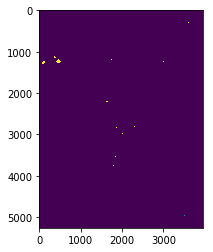

In [41]:
imshow(wet_proportion_allsensors.values)
plt.show()

In [42]:
wet_proportion_allsensors.()
plt.show()

SyntaxError: invalid syntax (<ipython-input-42-caf55a0bb0d8>, line 1)

In [ ]:
## grab the crs for the netdcf output 

In [43]:
crs = ds.crs

In [44]:
# if wetness_sensor1_nbart is not None:
#     crs = wetness_sensor1_nbart.crs
# else:
#     if wetness_sensor2_nbart is not None:
#         crs = wetness_sensor2_nbart.crs
#     else: 
#         crs = wetness_sensor3_nbart.crs
# print(crs)   

In [45]:
!pwd

/g/data1/r78/rjd547/jupyter_notebooks/GWandDEA_bex_ness/TCW_summary


In [46]:
write_your_netcdf(wet_proportion_allsensors,'tcw',filename='testwet1.nc', crs=crs)

In [47]:
print('successfully wrote tcw netcdf for '+shape_name+' polygon number '+str(i))
eprint('successfully wrote tcw netcdf for for '+shape_name+' polygon number '+str(i))

NameError: name 'shape_name' is not defined

In [ ]:
#clear_observations is count of wetness scenes at pixel
write_your_netcdf(wet_count_allsensors,'clearobs',filename=netcdf_output_loc+shape_name+'_clearobs.nc',crs=crs)
print('successfully wrote clearobs netCDF for '+shape_name+' polygon number '+str(i))
eprint('successfully wrote clearobs netCDFfor '+shape_name+' polygon number '+str(i))

In [48]:
!gdalwarp -of GTiff testwet1.nc testwet1.tif

Creating output file that is 3960P x 5259L.
Processing input file testwet1.nc.
Using internal nodata values (e.g. 9.96921e+36) for image testwet1.nc.
Copying nodata values from source testwet1.nc to destination testwet1.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [49]:
!ls


tasselled_cap_wetness_SStuartCorridor_090218.ipynb  testwet1.nc
TCW_Summary_Clean_011117.ipynb			    testwet1.tif
TCW_Summary_Clean_Dale_Coeffs _061117.ipynb
